In [1]:

import os, sys
sys.path.append(os.path.join('/home1/user/ken-takeda/COLOR/scripts/', '../'))

import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset

from src.color_embedding_MDS import MakeDataset, MainTraining, KFoldCV
from src.utils.utils import get_reorder_idxs
from src.embedding_model import torch_fix_seed


# fix all random seeds

torch_fix_seed()
torch.set_num_threads(1)
os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
### Set parameters
data = "neutyp" # "neutyp" or "atyp"

if data == "neutyp":
    N_participant = 426
    data_dir = "../data/color_neurotypical/numpy_data/"
elif data == "atyp":
    N_participant = 257
    data_dir = "../data/color_atypical/numpy_data/"


# sample participants
Z = 128
# sample
participants_list = random.sample(range(N_participant), Z)


# device 
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Train the model
emb_dim = 20
color_num = 93
num_color_pairs = 75 # 75

# Define the optimizer SGD
lr = 0.01
num_epochs = 100
batch_size = 100
early_stopping = False

lamb = 0.01

loss_fn = nn.MSELoss(reduction="sum")
distance_metric = "euclidean"

n_splits = 5


# load color codes
old_color_order = list(np.load('../data/hex_code/original_color_order.npy'))
new_color_order = list(np.load('../data/hex_code/new_color_order.npy'))
# get the reordering indices
reorder_idxs = get_reorder_idxs(old_color_order,new_color_order)



In [3]:
### Main computation
dataset = MakeDataset(participants_list=participants_list, data_dir=data_dir)


In [4]:
### shuffle the dataset
_dataset = dataset(N_trials=num_color_pairs)
_data = _dataset[:][0]
_labels = _dataset[:][1]

unique_values = torch.unique(_data)  
shuffled_idx = np.random.permutation(len(unique_values))
value_mapping = {val.item(): shuffled_idx[i] for i, val in enumerate(unique_values)} 

# map the data
mapped_data = torch.tensor([[value_mapping[val.item()] for val in row] for row in _data])

# get the shuffled dataset
shuffled_dataset = TensorDataset(mapped_data, _labels)

In [5]:
print("Original dataset:", _dataset[:10])
print("Shuffled  dataset:", shuffled_dataset[:10])

Original dataset: (tensor([[74, 63],
        [76, 38],
        [22,  0],
        [60, 46],
        [85, 26],
        [83, 38],
        [76,  3],
        [67, 50],
        [82, 42],
        [72, 39]]), tensor([1.0000, 6.5000, 7.0000, 5.5000, 7.0000, 5.5000, 6.5000, 6.0000, 7.0000,
        5.5000]))
Shuffled  dataset: (tensor([[59, 64],
        [79,  7],
        [78, 40],
        [50, 24],
        [74, 66],
        [23,  7],
        [79, 72],
        [41,  8],
        [ 2, 76],
        [32, 80]]), tensor([1.0000, 6.5000, 7.0000, 5.5000, 7.0000, 5.5000, 6.5000, 6.0000, 7.0000,
        5.5000]))


In [6]:
# Compute the color embeddings for the original dataset

main_training = MainTraining(dataset = _dataset, 
                                test_size = 1/n_splits, 
                                batch_size = batch_size, 
                                device = device)

color_embeddings, loss = main_training.main_compute(loss_fn = loss_fn, 
                            emb_dim = emb_dim, 
                            object_num = color_num, 
                            n_epoch = num_epochs, 
                            early_stopping=early_stopping,
                            lr = lr, 
                            distance_metric = distance_metric,
                            lamb=lamb,
                            show_log=False)

rearranged_color_embeddings = color_embeddings[reorder_idxs]

100%|██████████| 100/100 [00:07<00:00, 12.54it/s]


In [20]:
# Compute the color embeddings for the shuffled dataset
mapper = [list(value_mapping.values()).index(i) for i in range(len(value_mapping))]
main_training = MainTraining(dataset = shuffled_dataset, 
                                test_size = 1/n_splits, 
                                batch_size = batch_size, 
                                device = device)

shuffled_color_embeddings, loss = main_training.main_compute(loss_fn = loss_fn, 
                            emb_dim = emb_dim, 
                            object_num = color_num, 
                            n_epoch = num_epochs, 
                            early_stopping=early_stopping,
                            lr = lr, 
                            distance_metric = distance_metric,
                            lamb=lamb,
                            show_log=False, 
                            mapper=mapper)

torch.Size([93, 20])


100%|██████████| 100/100 [00:07<00:00, 12.79it/s]


In [21]:
# compare the two embeddings
# compute the distance matrix
from scipy.spatial.distance import cdist

# sort the mapping by the values
sorted_value_mapping = {k: v for k, v in sorted(value_mapping.items(), key=lambda item: item[1])}
inv_mapping = [list(sorted_value_mapping.keys()).index(i) for i in range(len(sorted_value_mapping))]
inv_color_embeddings = shuffled_color_embeddings[inv_mapping]
inv_rearranged_color_embeddings = inv_color_embeddings[reorder_idxs]

In [22]:

# compare the two embeddings
diff = inv_rearranged_color_embeddings - rearranged_color_embeddings

print("Difference:", diff)

Difference: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [23]:
# compare the RDM
RDM1 = cdist(rearranged_color_embeddings, rearranged_color_embeddings, metric=distance_metric)
RDM2 = cdist(inv_rearranged_color_embeddings, inv_rearranged_color_embeddings, metric=distance_metric)
# RDM2 = cdist(inv_color_embeddings, inv_color_embeddings, metric=distance_metric)
# RDM2 = cdist(shuffled_color_embeddings, shuffled_color_embeddings, metric=distance_metric)

diff_RDM = RDM1 - RDM2
print("Difference in RDM:", diff_RDM)

Difference in RDM: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


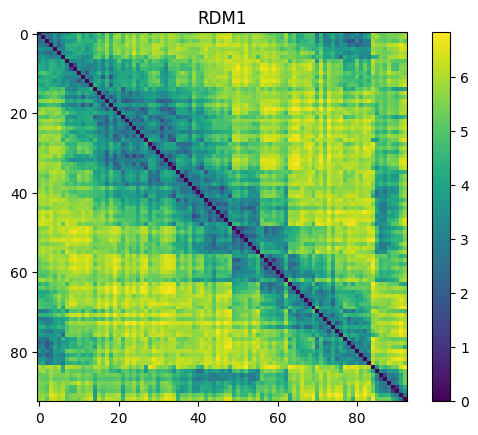

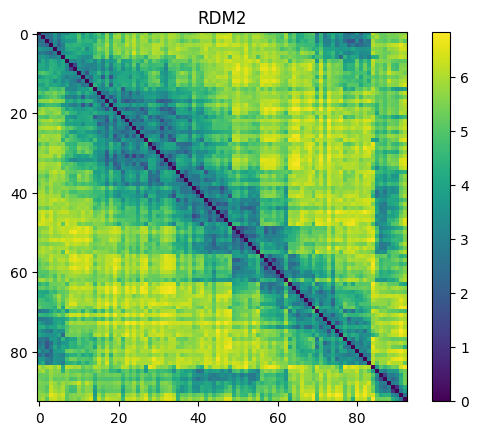

In [24]:
# visualize
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(RDM1)
plt.colorbar()
plt.title("RDM1")
plt.show()

plt.figure()
plt.imshow(RDM2)
plt.colorbar()
plt.title("RDM2")
plt.show()


In [25]:
# compute correlation between the two RDMs
from scipy.stats import spearmanr

corr, pval = spearmanr(RDM1.flatten(), RDM2.flatten())
print("Correlation:", corr, pval)

Correlation: 1.0 0.0
